In [151]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits


Credit for template notebook: Sarik Jeram

# General process (Mercury)
 1) Process your data
 2) Identify known lines in your spectrum
 3) Create line list
 4) Fit polynomial to line list (+ examine residuals)
 5) Apply wavelength solution to data!

In [152]:
path = '/Users/chris/Desktop/uf_grad_school/obs_tech/spectroscopy/'

In [153]:
dark0d1 = fits.getdata(path+'Pepito_lamp_spectra/dark_0d1s.FIT')
dark1 = fits.getdata(path+'Pepito_lamp_spectra/dark_1s.FIT')
dark2 = fits.getdata(path+'Pepito_lamp_spectra/dark_2s.FIT')

In [154]:
hg_spec = fits.getdata(path+'Pepito_lamp_spectra/mercury_0d1s.FIT')

In [155]:
hg_rect = hg_spec[364:434,:]

<IPython.core.display.Javascript object>


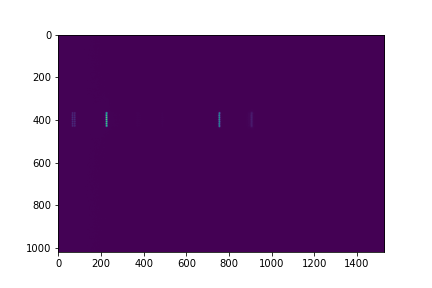

In [156]:
plt.figure()
plt.imshow(hg_spec)
plt.show()

<IPython.core.display.Javascript object>


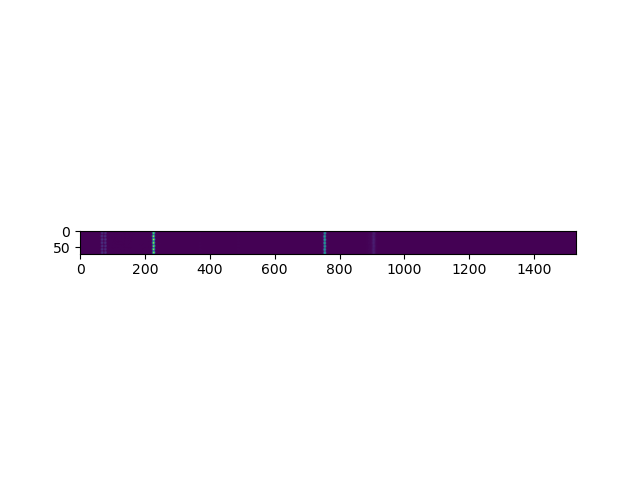

In [6]:
plt.figure()
plt.imshow(hg_rect)
plt.show()

In [7]:
hg_collapsed = np.median(hg_rect, axis=0)
detector_loc = np.arange(len(hg_collapsed))

<IPython.core.display.Javascript object>


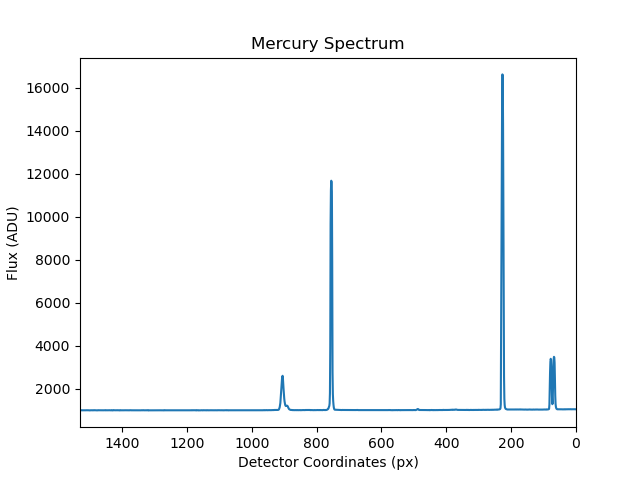

In [8]:
plt.figure()
plt.plot(detector_loc, hg_collapsed)
plt.xlim([1530, 0])
plt.xlabel('Detector Coordinates (px)')
plt.ylabel('Flux (ADU)')
plt.title('Mercury Spectrum')
plt.show()

In [9]:
def get_line_centroid(x_bounds, detector_px, flux):
    indcs = (detector_px > x_bounds[0]) & (detector_px < x_bounds[1])  # get the indices where we're in between the specified bounds
    x_i, m_i = detector_px[indcs], flux[indcs]  # apply the indices to our detector location and flux arrays
    return sum(x_i * m_i) / sum(m_i)  # return the centroid (flux weighted center-of-mass of the line)


print(f'{get_line_centroid([902, 908], detector_loc, hg_collapsed):.2f}')


905.04


In [ ]:
# Get lines from: https://physics.nist.gov/PhysRefData/Handbook/element_name.htm
# Generate a CSV file that includes thdetector location of the line as well as the wavelength you believe it is
# Use the centroiding function in the above cell instead of eye-ball estimates
"""
pepito_lines.csv:

lamp,wl_AA,loc_px
Hg,4046.563,905.1
Hg,4078,891.5
Hg,4358,754.5
Hg,5461,226.5
Hg,5770,77.6
Hg,5790,67.5
"""

In [235]:
line_data = np.genfromtxt('pepito_lines.csv', names=True, delimiter=',', dtype=float)  # load our file
#print(line_data[:-1])
#line_data = line_data[:-1]
wavelengths, locations = line_data['wl_AA'], line_data['loc_px']
argsort = np.argsort(locations)  # sort the wavelengths by their detector locations to prevent issues later on
locations, wavelengths=locations[argsort], wavelengths[argsort]  # apply the sorted indices to the original arrays

In [236]:
print(locations)
print(wavelengths)

[ 67.5  77.6 226.5 754.5 762.8 891.5 905.1]
[5790.    5770.    5461.    4358.    4340.462 4078.    4046.563]


In [237]:
coeffs = np.polyfit(locations, wavelengths, deg=5)  # determine coefficients for a polynomial of degree 5 to be fit to the data
print(coeffs)  # A*x^5 + B*x^4 + C*x^3 + D*x^2 + E*x + F; very small valued coefficients indicate you're probably over-fitting
polynomial = np.poly1d(coeffs)  # create a poly1d object from our coefficients for np.polyval to use
fitted_wavelengths = np.polyval(polynomial, locations)  # get the wavelength from the fit for the specified detector coordinates

[-2.76527794e-12  4.84931482e-09 -2.11298381e-06 -1.51861742e-04
 -1.94379155e+00  5.92250784e+03]


<IPython.core.display.Javascript object>


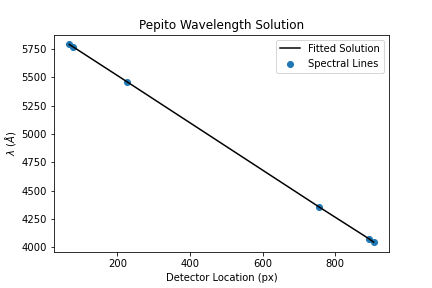

In [61]:
# Plot the fit
plt.figure()
plt.scatter(locations, wavelengths, label='Spectral Lines')
plt.plot(locations, fitted_wavelengths, c='k', label='Fitted Solution')
plt.xlabel('Detector Location (px)')
plt.ylabel(r'$\lambda$ ($\AA$)')
plt.title('Pepito Wavelength Solution')
plt.legend()
plt.show()


In [62]:
residuals = fitted_wavelengths - wavelengths
print(np.std(residuals)) # RMS of residuals

3.862379134031443e-12


<IPython.core.display.Javascript object>


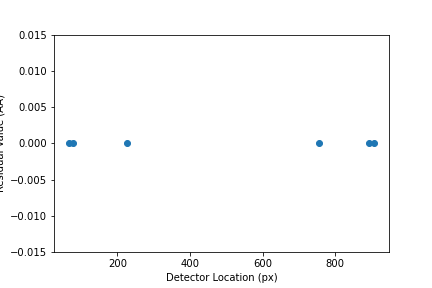

In [69]:
# Plot the residuals
%matplotlib notebook
plt.figure()
plt.scatter(locations, residuals, label='Residuals')
plt.xlabel('Detector Location (px)')
plt.ylabel('Residual Value (AA)')
plt.ylim([-0.015, 0.015])
plt.show()

### Hydrogen

In [41]:
h_spec = fits.getdata(path+'Pepito_lamp_spectra/hydrogen_1s.FIT')

<IPython.core.display.Javascript object>


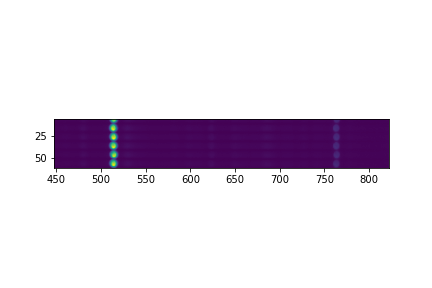

In [35]:
#%matplotlib inline
%matplotlib notebook
h_rect = h_spec[364:434,:]
plt.imshow(h_rect)
plt.show()

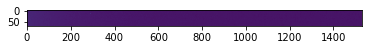

In [53]:
%matplotlib inline
d1_rect = dark1[364:434,:]
plt.imshow(d1_rect)
plt.show()

In [54]:
h_collapsed = np.median(h_rect-d1_rect, axis=0) # median-combine dark-subtracted rectangle of interest into 1D
detector_loc = np.arange(len(h_collapsed))

<IPython.core.display.Javascript object>


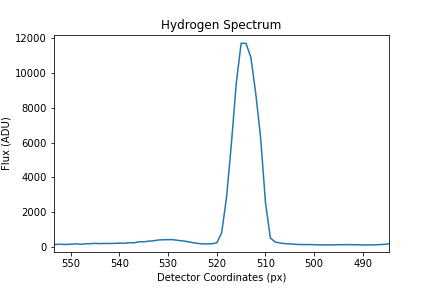

In [75]:
%matplotlib notebook
plt.figure()
plt.plot(detector_loc, h_collapsed)
plt.xlim([1530, 0])
plt.xlabel('Detector Coordinates (px)')
plt.ylabel('Flux (ADU)')
plt.title('Hydrogen Spectrum')
plt.show()

In [20]:
print(f'{get_line_centroid([755, 770], detector_loc, h_collapsed):.2f}')

762.75


In [17]:
print(f'{get_line_centroid([505, 525], detector_loc, h_collapsed):.2f}')

514.28


In [80]:
# Estimate wavelength of observed emission line in Hydrogen spectrum using our current wavelength solution
# Useful for guessing which line you're looking at in one of the other lamp spectra
print(np.polyval(polynomial, 763))
print(np.polyval(polynomial, 514)) # um, the nearest wavelength per NIST is 4861.3615 AA

4340.851071178095
4835.611518038177


In [ ]:
# I only added the 763 position line; omitted the brighter line because the exercise asks for Ne
# and I'm not getting anything too close to NIST for it
"""
pepito_lines.csv:

lamp,wl_AA,loc_px
Hg,4046.563,905.1
Hg,4078,891.5
Hg,4358,754.5
Hg,5461,226.5
Hg,5770,77.6
Hg,5790,67.5
H,4340.462,762.8
"""

### Neon

In [42]:
ne_spec = fits.getdata(path+'Pepito_lamp_spectra/neon_2s.FIT')

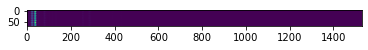

In [43]:
%matplotlib inline
#%matplotlib notebook
ne_rect = ne_spec[364:434,:]
plt.imshow(ne_rect)
plt.show()

In [81]:
dark2_rect = dark2[364:434,:]

In [82]:
ne_collapsed = np.median(ne_rect-dark2_rect, axis=0)
detector_loc = np.arange(len(ne_collapsed))

In [93]:
dark2_rect

array([[1047, 1044, 1035, ..., 1001, 1000,  991],
       [1036, 1040, 1057, ...,  995, 1000,  980],
       [1045, 1023, 1066, ...,  993, 1019, 1004],
       ...,
       [1048, 1038, 1060, ..., 1007, 1006,  992],
       [1063, 1050, 1073, ..., 1017, 1001, 1012],
       [1044, 1057, 1051, ..., 1016, 1027,  987]], dtype=uint16)

In [89]:
ne_collapsed

array([607. , 462.5, 429.5, ...,  19.5,  19. ,  22. ])

In [88]:
np.median(ne_rect, axis=0)

array([1660. , 1512.5, 1483.5, ..., 1009. , 1008. , 1008. ])

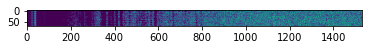

In [105]:
%matplotlib inline
plt.imshow(ne_rect-dark2_rect)
plt.show()

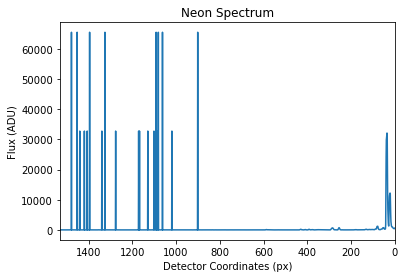

In [133]:
#%matplotlib notebook
plt.figure()
plt.plot(detector_loc, ne_collapsed)
plt.xlim([1530, 0])
plt.xlabel('Detector Coordinates (px)')
plt.ylabel('Flux (ADU)')
plt.title('Neon Spectrum')
plt.show()

In [46]:
print(f'{get_line_centroid([17, 28], detector_loc, ne_collapsed):.2f}')

22.71


In [47]:
print(f'{get_line_centroid([30, 43], detector_loc, ne_collapsed):.2f}')

36.82


In [126]:
print(f'{get_line_centroid([1018, 1020], detector_loc, ne_collapsed):.2f}')

1019.00


In [125]:
line_data = np.genfromtxt('pepito_lines.csv', names=True, delimiter=',', dtype=float)  # load our file
wavelengths, locations = line_data['wl_AA'], line_data['loc_px']
argsort = np.argsort(locations)  # sort the wavelengths by their detector locations to prevent issues later on
locations, wavelengths=locations[argsort], wavelengths[argsort]  # apply the sorted indices to the original arrays

In [128]:
# Estimate wavelength of observed emission line in Neon spectrum using our updated wavelength solution
# Useful for guessing which line you're looking at in one of the other lamp spectra
print(np.polyval(polynomial, 23))
print(np.polyval(polynomial, 37)) # um, the nearest wavelength per NIST is 4861.3615 AA
# this feels dirty bc they're saturated but it's either this or one line. Do I just go with one line??
print(np.polyval(polynomial, 1019))
print(np.polyval(polynomial, 1062))
print(np.polyval(polynomial, 1081))
print(np.polyval(polynomial, 1087))
print(np.polyval(polynomial, 1091))
print(np.polyval(polynomial, 1101))
print(np.polyval(polynomial, 1129))

5877.695928271692
5850.281519873976
3738.7167561191213
3588.9309447343485
3514.619955185109
3489.9888438866683
3473.2419966747093
3430.194797744225
3300.0540786397023


NIST yields (5872.8275 or 5881.8952...great, smack in the middle) and 5852.4879 AA 

#### Old Neon

tl;dr same problem: 2 lines, only one of which fits with the NIST table, if I don't dark subtract. If I do dark subtract, then I blow up

In [129]:
ne_spec0d3 = fits.getdata(path+'Pepito_lamp_spectra/old_neon/neon_blue_0d3s.fit')
ne_spec10 = fits.getdata(path+'Pepito_lamp_spectra/old_neon/neon_red_10s.fit')
dark0d3 = fits.getdata(path+'Pepito_lamp_spectra/old_neon/dark_0d3s.FIT')
dark10 = fits.getdata(path+'Pepito_lamp_spectra/old_neon/dark_10s.FIT')

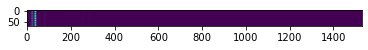

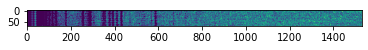

In [135]:
%matplotlib inline
ne_rect0d3 = ne_spec0d3[364:434,:]
dark_rect0d3 = dark0d3[364:434,:]
plt.imshow(ne_rect0d3)
plt.show()

plt.imshow(ne_rect0d3-dark_rect0d3)
plt.show()

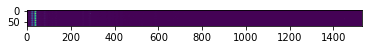

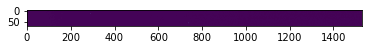

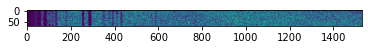

In [143]:
%matplotlib inline
ne_rect10 = ne_spec10[364:434,:]
dark_rect10 = dark10[364:434,:]

plt.imshow(ne_rect10)
plt.show()

plt.imshow(dark_rect10)
plt.show()

plt.imshow(ne_rect10-dark_rect10)
plt.show()

In [146]:
ne_collapsed0d3 = np.median(ne_rect0d3-dark_rect0d3, axis=0)
detector_loc = np.arange(len(ne_collapsed0d3))

<IPython.core.display.Javascript object>


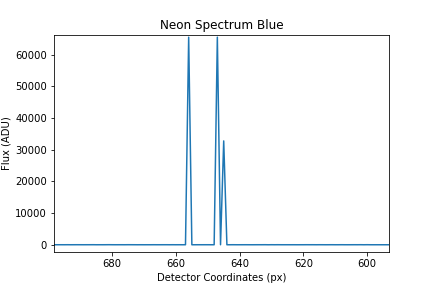

In [157]:
#%matplotlib notebook
plt.figure()
plt.plot(detector_loc, ne_collapsed0d3)
plt.xlim([1530, 0])
plt.xlabel('Detector Coordinates (px)')
plt.ylabel('Flux (ADU)')
plt.title('Neon Spectrum Blue')
plt.show()

In [158]:
ne_collapsed10 = np.median(ne_rect10-dark_rect10, axis=0)
detector_loc = np.arange(len(ne_collapsed10))

<IPython.core.display.Javascript object>


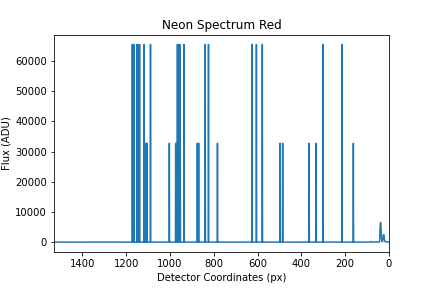

In [159]:
#%matplotlib notebook
plt.figure()
plt.plot(detector_loc, ne_collapsed10)
plt.xlim([1530, 0])
plt.xlabel('Detector Coordinates (px)')
plt.ylabel('Flux (ADU)')
plt.title('Neon Spectrum Red')
plt.show()

At this point, I learned that the lamp data for the spectroscopy project is way better, so...let's try with that data instead.

### Neon using spectroscopy project data

In [174]:
import imageio # welcome to bmp file land
ne_lamp1 = imageio.imread(path+'pepito_star_spectra/ne_lamp_1s.bmp')
ne_lamp12 = imageio.imread(path+'pepito_star_spectra/ne_lamp_1s_2.bmp')
print(ne_lamp1)
print(ne_lamp12)
print(ne_lamp1.shape)
ne_lamp1s = np.median(np.array(np.stack((ne_lamp1, ne_lamp12))), axis=0) # stack the two images and take median
print(ne_lamp1s)
print(ne_lamp1s.shape)

[[45 47 44 ... 45 37 36]
 [42 38 44 ... 39 38 36]
 [46 49 39 ... 37 37 41]
 ...
 [39 31 33 ... 34 37 33]
 [40 33 31 ... 37 40 43]
 [36 38 33 ... 35 43 35]]
[[31 30 32 ... 33 27 25]
 [32 28 29 ... 25 28 21]
 [32 40 26 ... 22 25 22]
 ...
 [27 24 26 ... 22 26 26]
 [25 21 22 ... 21 30 32]
 [30 31 22 ... 27 29 26]]
(1200, 1600)
[[38.  38.5 38.  ... 39.  32.  30.5]
 [37.  33.  36.5 ... 32.  33.  28.5]
 [39.  44.5 32.5 ... 29.5 31.  31.5]
 ...
 [33.  27.5 29.5 ... 28.  31.5 29.5]
 [32.5 27.  26.5 ... 29.  35.  37.5]
 [33.  34.5 27.5 ... 31.  36.  30.5]]
(1200, 1600)


In [175]:
# now darks
dark11 = imageio.imread(path+'pepito_star_spectra/dark_1s_1.bmp')
dark12 = imageio.imread(path+'pepito_star_spectra/dark_1s_2.bmp')
dark13 = imageio.imread(path+'pepito_star_spectra/dark_1s_3.bmp')
dark_1s = np.median(np.array(np.stack((dark11, dark12, dark13))), axis=0)
print(dark_1s.shape)

(1200, 1600)


<IPython.core.display.Javascript object>


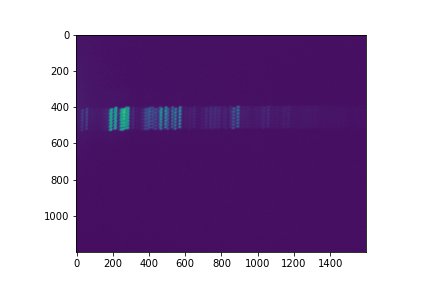

In [176]:
plt.figure()
plt.imshow(ne_lamp1s)
plt.show()

<IPython.core.display.Javascript object>


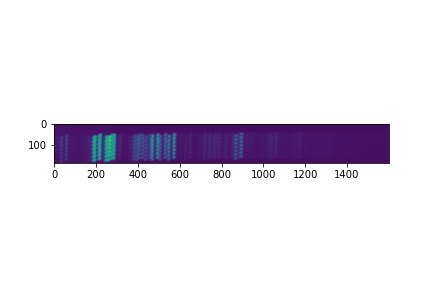

In [178]:
ne_rect1 = ne_lamp1s[355:539,:]
plt.figure()
plt.imshow(ne_rect1)
plt.show()

<IPython.core.display.Javascript object>


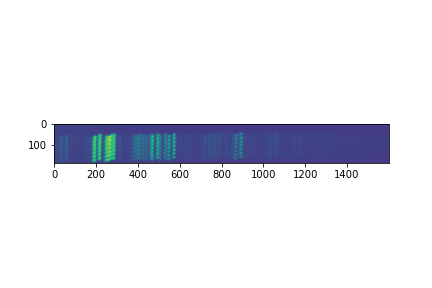

In [180]:
dark_rect1 = dark_1s[355:539,:]
plt.figure()
plt.imshow(ne_rect1-dark_rect1)
plt.show()

In [181]:
ne_collapsed = np.median(ne_rect1-dark_rect1, axis=0)
detector_loc = np.arange(len(ne_collapsed))

<IPython.core.display.Javascript object>


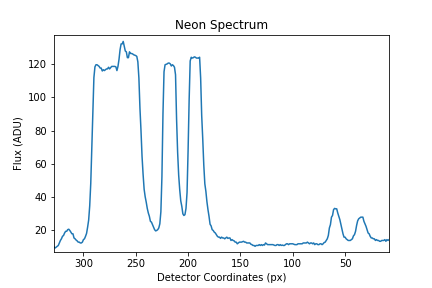

In [185]:
plt.figure()
plt.plot(detector_loc, ne_collapsed)
plt.xlim([1530, 0])
plt.xlabel('Detector Coordinates (px)')
plt.ylabel('Flux (ADU)')
plt.title('Neon Spectrum')
plt.show()

<IPython.core.display.Javascript object>


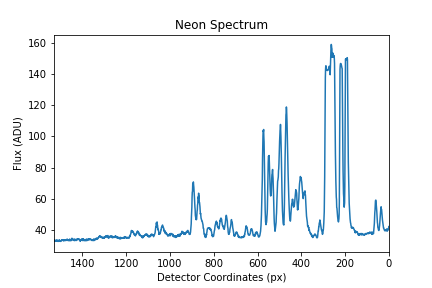

In [186]:
# how about without dark subtraction
plt.figure()
plt.plot(detector_loc, np.median(ne_rect1, axis=0))
plt.xlim([1530, 0])
plt.xlabel('Detector Coordinates (px)')
plt.ylabel('Flux (ADU)')
plt.title('Neon Spectrum')
plt.show()

Darks don't seem to mess things up this time...but I don't think the two takes were perfectly aligneed so it might just be better to go off one dark-subtracted image

<IPython.core.display.Javascript object>


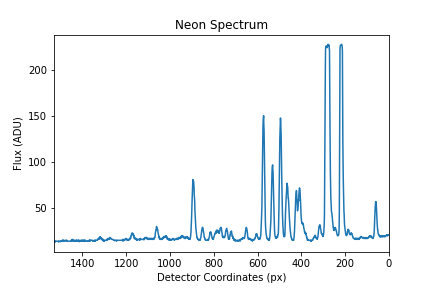

In [250]:
# ne lamp 1s
plt.figure()
ne_rect1_dark = np.median(ne_lamp1[355:539,:]-dark_rect1, axis=0)
plt.plot(detector_loc, ne_rect1_dark)
plt.xlim([1530, 0])
plt.xlabel('Detector Coordinates (px)')
plt.ylabel('Flux (ADU)')
plt.title('Neon Spectrum')
plt.show()

In [234]:
print(f'{get_line_centroid([50, 70], detector_loc, ne_rect1_dark):.2f}') # rightmost line
print(f'{get_line_centroid([200, 230], detector_loc, ne_rect1_dark):.2f}') # big ol line
print(f'{get_line_centroid([260, 297], detector_loc, ne_rect1_dark):.2f}') # other big ol line
print(f'{get_line_centroid([403, 417], detector_loc, ne_rect1_dark):.2f}') # doublet 
print(f'{get_line_centroid([417, 428], detector_loc, ne_rect1_dark):.2f}') # doublet
print(f'{get_line_centroid([450, 477], detector_loc, ne_rect1_dark):.2f}')
print(f'{get_line_centroid([480, 508], detector_loc, ne_rect1_dark):.2f}')
print(f'{get_line_centroid([519, 545], detector_loc, ne_rect1_dark):.2f}')
print(f'{get_line_centroid([559, 587], detector_loc, ne_rect1_dark):.2f}')
print(f'{get_line_centroid([878, 905], detector_loc, ne_rect1_dark):.2f}')
print(f'{get_line_centroid([1045, 1079], detector_loc, ne_rect1_dark):.2f}')


59.52
216.28
279.33
409.68
422.49
463.36
494.22
531.57
572.77
892.29
1061.50


In [238]:
# Estimate wavelength for easier identification in NIST
print(np.polyval(polynomial, 59.52)) # y 5804.4496
print(np.polyval(polynomial, 216.28)) # n 
print(np.polyval(polynomial, 279.33)) # y 5343.2834 or 5341.0938?
print(np.polyval(polynomial, 409.68)) # n 
print(np.polyval(polynomial, 422.49)) # y 5037.7512
print(np.polyval(polynomial, 463.36)) # n 
print(np.polyval(polynomial, 494.22)) # y? 4884.9170
print(np.polyval(polynomial, 531.57)) # y? 4790.2195 or 4788.9258?
print(np.polyval(polynomial, 572.77)) # y 4712.0633 or 4715.344?
print(np.polyval(polynomial, 892.29)) # n
print(np.polyval(polynomial, 1061.50)) # y 3593.5257


5805.888631481503
5482.926136566432
5346.467308970244
5060.08906912945
5032.103232086043
4943.492721036641
4877.460257583969
4798.779588932935
4713.749364835807
4075.9451311546295
3590.8140708589785


<IPython.core.display.Javascript object>


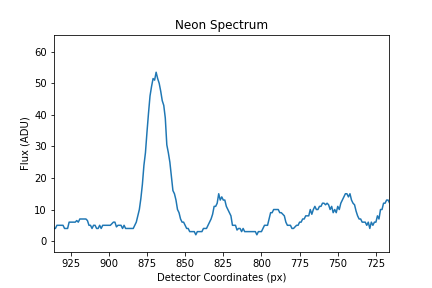

In [213]:
# ne lamp 1s second take
plt.figure()
ne_rect12_dark = np.median(ne_lamp12[355:539,:]-dark_rect1, axis=0)
plt.plot(detector_loc, ne_rect12_dark)
plt.xlim([1530, 0])
plt.xlabel('Detector Coordinates (px)')
plt.ylabel('Flux (ADU)')
plt.title('Neon Spectrum')
plt.show()

In [224]:
print(f'{get_line_centroid([24.5, 46], detector_loc, ne_rect1_dark):.2f}') # rightmost line
print(f'{get_line_centroid([177, 203], detector_loc, ne_rect1_dark):.2f}') # big ol line
print(f'{get_line_centroid([237, 271], detector_loc, ne_rect1_dark):.2f}') # other big ol line
print(f'{get_line_centroid([379, 391], detector_loc, ne_rect1_dark):.2f}') # doublet 
print(f'{get_line_centroid([391, 405], detector_loc, ne_rect1_dark):.2f}') # doublet
print(f'{get_line_centroid([423, 455], detector_loc, ne_rect1_dark):.2f}')
print(f'{get_line_centroid([455, 486], detector_loc, ne_rect1_dark):.2f}')
print(f'{get_line_centroid([496, 522], detector_loc, ne_rect1_dark):.2f}')
print(f'{get_line_centroid([536, 565], detector_loc, ne_rect1_dark):.2f}')
print(f'{get_line_centroid([851, 885], detector_loc, ne_rect1_dark):.2f}')


35.07
190.27
259.45
385.34
398.74
436.68
467.45
504.02
549.31
868.49


In [225]:
# Estimate wavelength for easier identification in NIST
print(np.polyval(polynomial, 35.07)) # y 5852.4879
print(np.polyval(polynomial, 190.27)) # n
print(np.polyval(polynomial, 259.45)) # n
print(np.polyval(polynomial, 385.34)) # n
print(np.polyval(polynomial, 398.74)) # n
print(np.polyval(polynomial, 436.68)) # y 5005.1587
print(np.polyval(polynomial, 467.45)) # n
print(np.polyval(polynomial, 504.02)) # n
print(np.polyval(polynomial, 549.31)) # y? 4752.7320
print(np.polyval(polynomial, 868.49)) # n 

5854.068342973601
5538.276075639834
5389.788397836066
5113.462459045553
5084.050678031792
5001.209631758886
4934.693234713482
4856.677022881215
4761.933177413039
4128.195590085632


In [257]:
line_data = np.genfromtxt(path+'pepito_star_spectra/pepito_lines.csv', names=True, delimiter=',', dtype=float)  # load our file
line_data = line_data[:-1]
wavelengths, locations = line_data['wl_AA'], line_data['loc_px']
argsort = np.argsort(locations)  # sort the wavelengths by their detector locations to prevent issues later on
locations, wavelengths=locations[argsort], wavelengths[argsort]  # apply the sorted indices to the original arrays
print(locations)
print(wavelengths)


[ 59.52 279.33 422.49 494.22 531.57 572.77]
[5804.4496 5343.2834 5037.7512 4884.917  4790.2195 4712.0633]


In [258]:
coeffs = np.polyfit(locations, wavelengths, deg=5)  # determine coefficients for a polynomial of degree 5 to be fit to the data
print(coeffs)  # A*x^5 + B*x^4 + C*x^3 + D*x^2 + E*x + F; very small valued coefficients indicate you're probably over-fitting
polynomial = np.poly1d(coeffs)  # create a poly1d object from our coefficients for np.polyval to use
fitted_wavelengths = np.polyval(polynomial, locations)  # get the wavelength from the fit for the specified detector coordinates


[ 6.83202844e-10 -1.25283585e-06  8.62490328e-04 -2.70814279e-01
  3.43206137e+01  4.55443217e+03]


<IPython.core.display.Javascript object>


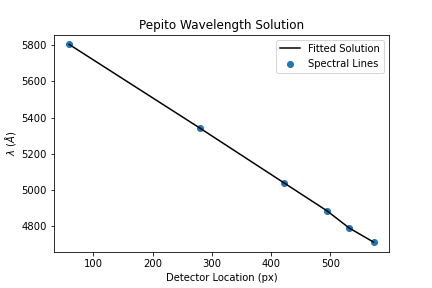

In [259]:
# Plot the fit
plt.figure()
plt.scatter(locations, wavelengths, label='Spectral Lines')
plt.plot(locations, fitted_wavelengths, c='k', label='Fitted Solution')
plt.xlabel('Detector Location (px)')
plt.ylabel(r'$\lambda$ ($\AA$)')
plt.title('Pepito Wavelength Solution')
plt.legend()
plt.show()

In [260]:
residuals = fitted_wavelengths - wavelengths
print(np.std(residuals)) # RMS of residuals

1.4384367880947875e-11


<IPython.core.display.Javascript object>


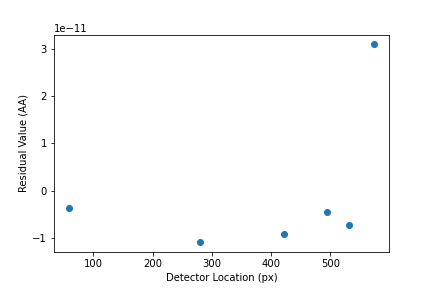

In [261]:
# Plot the residuals
%matplotlib notebook
plt.figure()
plt.scatter(locations, residuals, label='Residuals')
plt.xlabel('Detector Location (px)')
plt.ylabel('Residual Value (AA)')
#plt.ylim([-0.015, 0.015])
plt.show()

<IPython.core.display.Javascript object>


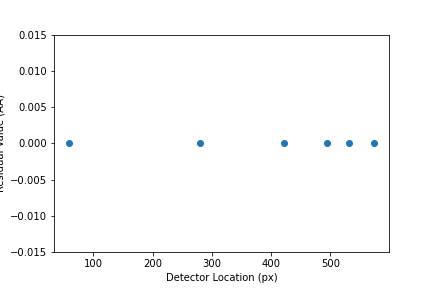

In [262]:
plt.figure()
plt.scatter(locations, residuals, label='Residuals')
plt.xlabel('Detector Location (px)')
plt.ylabel('Residual Value (AA)')
plt.ylim([-0.015, 0.015])
plt.show()